# Mod-2 Projet Linear Regression
## Progression of Depressive Symptoms
### Using National Health and Nutrition Examination Survey Data

Here, we are interested in learning what are the key factors that contribute to the development of depressive symptoms in order to decide which area to prioritize fundings for research in suicide prevention. I'm primarily using the National Health and Nutrition Examination Survey obtained from CDC website.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

import pickle

import scipy.stats as st
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import jarque_bera

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
pd.options.mode.chained_assignment = None  

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Collection
I downloaded 2017-2018 survey data from CDC website. (https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=2017)

Survey data are divided into different sections, so I'll merge all of these files.

In [2]:
fname = !ls DATA/2017-2018

In [3]:
#setting initial dataframe
df = pd.read_sas("DATA/2017-2018/BMX_J.XPT", format = 'xport')


In [4]:
#merge the rest of XPT files
for f in fname[1:]: 
    s_df = pd.read_sas(f"DATA/2017-2018/{f}", format = 'xport')
    df = df.merge(s_df, on='SEQN', how = 'outer')

In [5]:
df.sample(3)

,SEQN,BMDSTATS,BMXWT,BMIWT,BMXRECUM,BMIRECUM,BMXHEAD,BMIHEAD,BMXHT,BMIHT,...,WHD080U,WHD080L,WHQ225,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ190,WHQ200
7663,101834.0,1.0,94.3,NaN,NaN,NaN,NaN,NaN,161.9,NaN,...,NaN,NaN,1.0,214.0,130.0,64.0,220.0,54.0,2.0,NaN
1511,95299.0,1.0,23.8,NaN,NaN,NaN,NaN,NaN,124.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3419,97321.0,1.0,68.6,NaN,NaN,NaN,NaN,NaN,164.1,NaN,...,NaN,NaN,5.0,140.0,135.0,NaN,165.0,35.0,2.0,NaN


In [6]:
# making sure there's no duplicate subject.
df[df.duplicated(subset = 'SEQN')]

,SEQN,BMDSTATS,BMXWT,BMIWT,BMXRECUM,BMIRECUM,BMXHEAD,BMIHEAD,BMXHT,BMIHT,...,WHD080U,WHD080L,WHQ225,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ190,WHQ200


# Dependent Variable (DV)
What I am interested in is studying what factors explain the variation in one's mental health the most in the population observing some depressive symptoms. To quantify one's mental health, I will create a mental health index as DV, using the cumulative scores from the questionnaires under Mental Health - Depression Screener section. (Please note that the goal is not to diagnose a mental disorder, but to have a baseline understanding of progression of depressive symptom in order to aid suicide prevention research.) 

I'll also narrow down the subjects to those who have answered to have experienced at least some level of depressive symptoms, as we are interested in knowing how to prevent people with mental health concerns to develop serious symptoms, not about mental health of general population.

First I'll eliminate the subjects missing all of these scores, since we don't have any measure to infer these data. But if only some of these columns are missing, we will infer from other answers they provided.  

In [7]:
# select only depression screener columns and subject number
cols = ['SEQN'] + [c for c in df.columns if c.startswith('DPQ')]
DPQ = df.loc[:, cols]
DPQ.SEQN = DPQ.SEQN.apply(lambda x: str(x))

In [8]:
DPQ.describe() # it seems like 0 didn't get converted properly

,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100
count,5.094000e+03,5.093000e+03,5.093000e+03,5.092000e+03,5.092000e+03,5.091000e+03,5.091000e+03,5.091000e+03,5.090000e+03,3.362000e+03
mean,3.992933e-01,3.593167e-01,6.465737e-01,7.617832e-01,3.994501e-01,2.567276e-01,2.722451e-01,1.791397e-01,6.149312e-02,3.277811e-01
std,8.201561e-01,7.668570e-01,9.911066e-01,9.754442e-01,8.171601e-01,7.001904e-01,7.219092e-01,6.272503e-01,3.969209e-01,6.428110e-01
min,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
25%,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
50%,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
75%,1.000000e+00,5.397605e-79,1.000000e+00,1.000000e+00,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.000000e+00
max,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00


In [9]:
# all of these should be integers
for c in DPQ.columns[1:]:
    DPQ[c] = DPQ[c].apply(lambda x: np.nan if math.isnan(x) else int(x))

### Data transformation 
7 is Refused to answer and 9 is don't know.  So we will turn these into nan values. 

In [10]:
DPQ = DPQ.replace(7, np.nan)
DPQ = DPQ.replace(9, np.nan)

## Mental Health Measure EDA

### Missing sub-value for DV 
DPQ100 is conditional to have answered high on other columns (If responded to any of the other question with 1, 2 or 3) So we can safely assume that if only this value is missing, it means 0. 

If more than half of these questionnaires (exc. DPQ100, >= 5) are missing, we will drop the subject. Otherwise, we will infer from other highest correlated column value.

In [18]:
# If DPQ100 is missing, replace it with 0.
DPQ.DPQ100 = DPQ.DPQ100.replace(np.nan, 0)

In [19]:
# If there are more than half columns missing, drop the subject.
DPQ = DPQ.drop(DPQ[DPQ.isnull().sum(axis = 1) > 4].index, axis = 0)

In [20]:
# look at the columns with missing values
#DPQ.isnull().sum()

There are some missing values. We will replace it with the highest correlated column value.

In [21]:
# select the value that correlates the most with each columns
tmp = DPQ.dropna().iloc[:, 1:10]
cols = list(DPQ.columns)[1:10]
cor_dict = {}
for c in cols: 
    Y = tmp[c]
    X = tmp.drop(c, axis = 1)
    corr_ = X.corrwith(Y)
    max_ = corr_[corr_ == max(corr_)]
    cor_dict[c] = (list(max_.index)[0], max_[0])

In [22]:
# fill NA with the value from highest correlated questionnarie
for k, v in cor_dict.items():
    DPQ[k] = DPQ[k].fillna(DPQ[v[0]])

In [23]:
# there are a few that could not be filled (probably because both variables were empty). 
# There aren't that many so I'll drop these ones.
DPQ = DPQ.dropna(axis = 0)

In [24]:
# Fill the rest of missing values with the row means - not running
# DPQ = DPQ.T.fillna(DPQ.mean(axis=1)).T

Before diving into the features and subsetting the dataset, let's take a look at how overall population has answered on the mental health questionnaires. Each questions are rated at same scale (0-3: Not at all, several days, more than half the days, nearly every day). Questions are as below.  
DPQ010: Have little interest in doing things  
DPQ020: Feeling down, depressed, or hopeless  
DPQ030: Trouble sleeping or sleeping too much  
DPQ040: Feeling tired or having little energy  
DPQ050: Poor appetite or overeating  
DPQ060: Feeling bad about yourself  
DPQ070: Trouble concentrating on things  
DPQ080: Moving or speaking slow or too fast or fidgety and restless  
DPQ090: Thought you would be better off dead or of hurting yourself  
DPQ100: Difficulty these problems have caused (not at all, somewhat, very, extremely)   

In [25]:
# set up to plot percentiles
tmp = DPQ.drop('SEQN', axis = 1)
tmp = tmp.fillna(0)
tmp = tmp.apply(pd.value_counts)
tmp = tmp.div(len(DPQ), axis = 1)

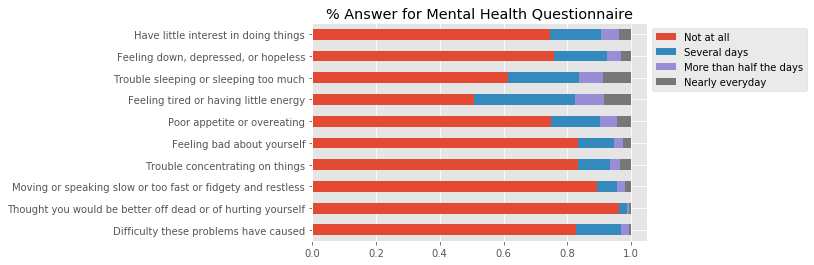

In [26]:
plt.style.use('ggplot')

tmp.T.plot(kind = 'barh', stacked = True)
plt.legend(['Not at all', 'Several days', 'More than half the days', 'Nearly everyday'], 
          bbox_to_anchor=(1, 1))
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
           ['Have little interest in doing things', 
            'Feeling down, depressed, or hopeless', 
            'Trouble sleeping or sleeping too much' , 
            'Feeling tired or having little energy', 
            'Poor appetite or overeating', 
            'Feeling bad about yourself', 
            'Trouble concentrating on things', 
            'Moving or speaking slow or too fast or fidgety and restless',
            'Thought you would be better off dead or of hurting yourself', 
            'Difficulty these problems have caused'])
plt.title('% Answer for Mental Health Questionnaire')

plt.gca().invert_yaxis()
plt.savefig('PNG/p_answers_pop.png', dpi=150, bbox_inches='tight')
plt.show()

## Add MH_Index
I will now create a new column MH_Index (Mental Health Index), which is the cumulative score of all these questionnaire.

In [568]:
# sum of each row as MH_Index
DPQ['MH_Index'] = DPQ.sum(axis = 1)

## Subsetting dataset
The ultimate purpose of my research is to reduce suicide rate. So I'm interested in what factors may affect the people to go from depressive symptom to suicidal thouoght. So participants who answered to not feel depressed at all are not relevant to this question. Including them may also potentially skew the model and weaken the relationship to factors that has stronger influence on people with some depressive symptoms. So I'll remove these participants. 

In [21]:
DPQ = DPQ[DPQ.DPQ020 > 0]

No handles with labels found to put in legend.


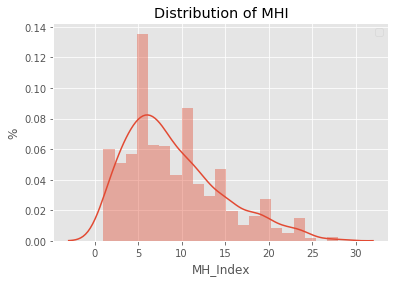

In [556]:
sns.distplot(DPQ['MH_Index'])
plt.legend()
plt.title("Distribution of MHI")
plt.ylabel('%')
plt.savefig('PNG/MHI_distributionn.png', dpi = 150)

Right skewed, as expected. Let's try to approximate normality, and check if this fits our model better.

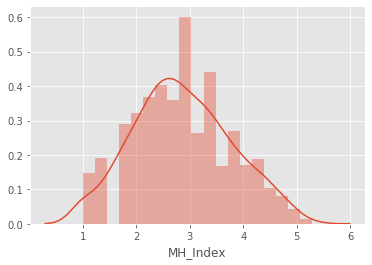

In [23]:
sns.distplot(np.sqrt(DPQ['MH_Index']))
DPQ['MH_Index_sq'] = np.sqrt(DPQ['MH_Index'])

## Dependent Variable : MH_Index

# Selecting Independent Variables
There are over 1500 measures available, of which, I inluded about 640 features based on its broad topics. I will first look at the measures that highly correlate with the DV first, then feature engineer any other ones I think will matter. As a brainstorming, below are the ones I think may have influence. 

**Topics**
0. General Demographics
    - Age
    - Gender
    - Race
    - Sexual Identity
    - Income
    - Household (Family size)
    - Emplyment Status / Occupation (OCQ)
    - Education level 
    - Veterans
1. Existing Conditions
    - Disability (DLQ)
    - Physical Functioning (PFQ)
    - Medical Conditions (MCQ)
    - Sleep (SLQ)
2. Hormone Level
    - (need more research) 
3. Accessibility to Care
    - Visit to health care professional (HUQ061)
    - Visit to mental health professional (HUQ090)
4. Lifestyle (ability to maintain)
    - Physical Activity (PAQ)
    - Food security (FSQ)
5. Diet & Nutrition (CBQ/DBQ)
6. Substance Abuse (DUQ, ALQ)
7. Pregnancy


### Merging DV with features (narrow it to subset)

In [24]:
df.SEQN = df.SEQN.astype('str')

In [25]:
# merge DV to narrow down the subjects
MHI = DPQ[['SEQN', 'MH_Index', 'MH_Index_sq']]
select_df = MHI.merge(df, on ="SEQN")

#### Looking at correlations
Since the IVs are not yet cleaned, this is not exactly accurate measure, but I'll use this to help me decide which area to prioritize.

In [26]:
# quick overview of correlations. 
tmp = select_df.dropna(how = 'all', axis = 1)
a = list(tmp.columns[tmp.isnull().sum() < (len(tmp)/2)]) # at least 50% of data's in.
tmp = tmp[a]
corta = tmp.corrwith(tmp['MH_Index'])

In [27]:
sel_cols = list(corta[abs(corta).sort_values(ascending = False) > 0.3].index)

In [28]:
# sel_cols

Based on these correlations, which shows some correlation on medical condition and physical functioning, and my initial list, I will focus on these features, for the sake of time.

1. Demographics
    - Especially gender and income
2. Medical conditions
    - BMI / obesity (if time, dietary choices)
    - Chronic illness 
    - Chronic illness x years of living with the disease
    - Disability / physical function
3. Substance abuse
    - Use of drug
    - Use of tobacco products
    - Use of alcohol

## Demographics

### Age
Survey age was capped at 80, meaning age of anyone older was inputted as 80. To adapt to this, I'll add some noise to this data by dispersing the data with age 80 to be random integer between 80 to 90.  
Otherwise we see that it's heavy on 18 years old, and rest are more or less noisy.  

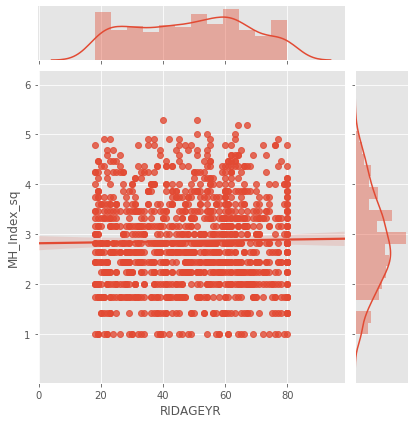

In [29]:
sns.jointplot("RIDAGEYR", "MH_Index_sq", data=select_df, kind="reg")

Not much relationship here.

In [30]:
select_df['age'] = select_df.RIDAGEYR.apply(lambda x: np.random.randint(80, 90, 1)[0] if x == 80 else x)

In [31]:
select_df.age.isnull().sum()

0

### Gender

In [32]:
# new column with more intuitive name
select_df['gender'] = select_df["RIAGENDR"]

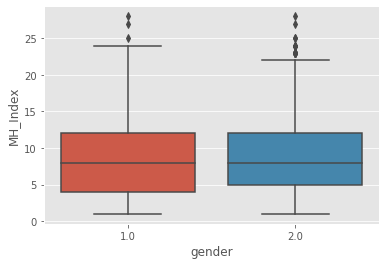

In [33]:
sns.boxplot(x="gender", y="MH_Index", data=select_df)

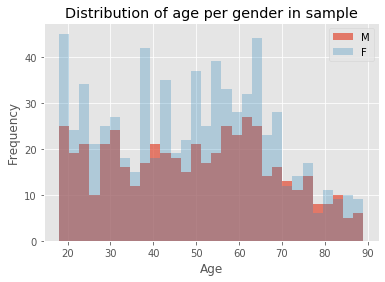

In [34]:
select_df.age[select_df.gender == 1].plot(kind = 'hist', bins = 30, alpha = 0.7, label = "M")
select_df.age[select_df.gender == 2].plot(kind = 'hist', bins = 30, alpha = 0.3, label = "F")
plt.legend()
plt.title("Distribution of age per gender in sample")
plt.xlabel('Age')
plt.savefig('PNG/age_gender_sm.png', dpi = 150)

About 60% of the sample are female.

In [35]:
select_df.gender.value_counts(normalize = True)

2.0    0.590835
1.0    0.409165
Name: gender, dtype: float64

In [36]:
select_df.gender.isnull().sum()

0

### Compare genders (two sample t-test)
Let's see if the difference between the gender is significant.

In [37]:
st.ttest_ind(select_df.MH_Index[select_df.gender == 1], select_df.MH_Index[select_df.gender == 2])

Ttest_indResult(statistic=-1.262991395255574, pvalue=0.2068335990694089)

At significance level of 0.05, MH index scores of male and female are not significantly different. (It was significant in the year 2013-2014, but not in this dataset.) I will consider not including this in the final model, also I'll prioritize other variables for feature engineering. 

### Total number of household
Most households have 2 people, followed by 3, 1, 4.

In [38]:
select_df['total_household'] = select_df['DMDHHSIZ']

In [39]:
# make them an integer (0 value is messy)
select_df.total_household = select_df.total_household.apply(lambda x: int(x))

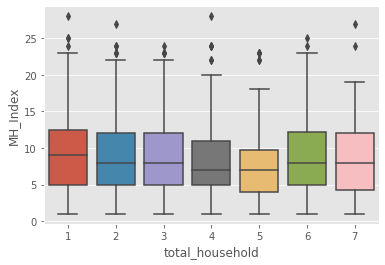

In [40]:
sns.boxplot(x="total_household", y="MH_Index", data=select_df)

A household number does not seem to make much influence.

In [41]:
select_df.total_household.isnull().sum()

0

#### Household types
I want to know in detail how different household types may affect the mental health index. Single mom and a couple are both two people households but their living situation can be very different. I'll create a new feature "n_dependents" and add up all children numbers (under 5 or under 17). Then add a new feature "n_adults", a household number subtracting children numbers, and make an interaction between the two.

In [42]:
select_df['n_dependents'] = select_df['DMDHHSZA'] + select_df['DMDHHSZB']
select_df.n_dependents = select_df.n_dependents.apply(lambda x: int(x))
select_df['n_adults'] = select_df['total_household'] - select_df['n_dependents']
select_df.n_adults.value_counts()

2    544
3    245
1    237
4    151
5     40
6      4
7      1
Name: n_adults, dtype: int64

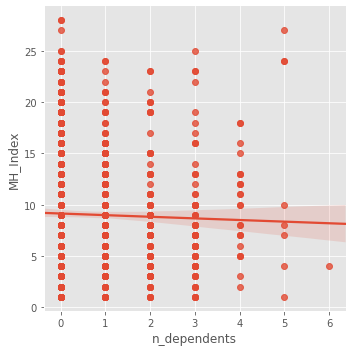

In [43]:
sns.lmplot(x="n_dependents", y="MH_Index", data=select_df)

It seems like there could be (weak) relationship, but that's a maybe. Let's check.  
### ANOVA
It seems like there could be some relationship. But residuals are not normal, so we cannot run ANOVA. We should run Kruskal Wallis.

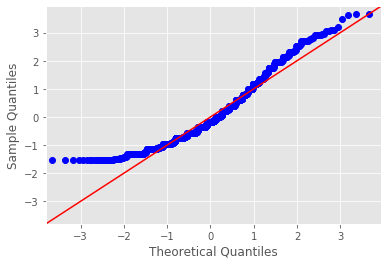

In [44]:
mod = ols('MH_Index ~ n_dependents', data = select_df).fit()
fig = sm.qqplot(mod.resid, st.t, fit=True, line='45')

In [45]:
x1 = select_df[select_df.n_dependents == 0].MH_Index
x2 = select_df[select_df.n_dependents == 1].MH_Index
x3 = select_df[select_df.n_dependents == 2].MH_Index
x4 = select_df[select_df.n_dependents == 3].MH_Index
x5 = select_df[select_df.n_dependents == 4].MH_Index
x6 = select_df[select_df.n_dependents == 5].MH_Index

st.kruskal(x1, x2, x3, x4, x5, x6)

KruskalResult(statistic=10.69718472058165, pvalue=0.05772570077695955)

We failed to reject the null at significance level of 0.05 (Marginal significance, p < 0.1)).   
It seems like the difference is not really significant.  
How about number of adults?

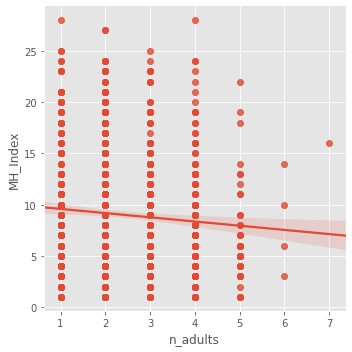

In [46]:
sns.lmplot(x="n_adults", y="MH_Index", data=select_df)

In [47]:
x2 = select_df[select_df.n_adults == 1].MH_Index
x3 = select_df[select_df.n_adults == 2].MH_Index
x4 = select_df[select_df.n_adults == 3].MH_Index
x5 = select_df[select_df.n_adults == 4].MH_Index
x6 = select_df[select_df.n_adults == 5].MH_Index
x7 = select_df[select_df.n_adults == 6].MH_Index

st.kruskal(x2, x3, x4, x5, x6)

KruskalResult(statistic=10.939132745409085, pvalue=0.027256662627727416)

At the significance level of 0.05, we reject the null. There are significant difference in MH Index between number of adults (one or more of the pairs at least). I will dive deeper into the relationship between number of adult and other variable.)

#### Have a child and Only adults
I'll also add in a binary variable to indicate whether a person is a only adult or not.

In [48]:
select_df['only_adult'] = np.where(select_df.n_adults == 1, 1, 0)


#### Interaction
It's hard to tell if there's any obvious interaction here. Possibly when there's only adult. I will add this as an interaction and see if they improve the model later.

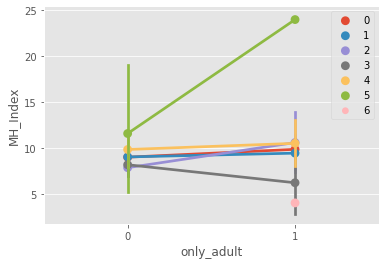

In [49]:
# any interaction between number of adults and children?
sns.pointplot(x = 'only_adult', y = 'MH_Index', hue = 'n_dependents', data = select_df)
plt.legend(bbox_to_anchor = [1, 1])

### Income (Total household income as a range value in dollars)
They are tiered. I'll put the mean value of the interval.

In [50]:
# changing couple variable name to somethign more intuitive
select_df['income'] = select_df["INDFMIN2"]

In [51]:
cond = [
    select_df.income == 1, 
    select_df.income == 2, 
    select_df.income == 3, 
    select_df.income == 4, 
    select_df.income == 5, 
    select_df.income == 6, 
    select_df.income == 7, 
    select_df.income == 8, 
    select_df.income == 9, 
    select_df.income == 10, 
    select_df.income == 12, 
    select_df.income == 13, 
    select_df.income == 14, 
    select_df.income == 15 
]
vals = [np.mean([0, 4999]), np.mean([5000, 9999]), np.mean([10000, 14999]), 
       np.mean([15000, 19999]), np.mean([20000, 24999]), np.mean([25000, 34999]), 
       np.mean([35000, 44999]), np.mean([45000, 54999]), np.mean([55000, 64999]), 
       np.mean([65000, 74999]), np.mean([20000, 40000]), np.mean([0, 20000]), 
       np.mean([75000, 99999]), np.mean([100000, 200000])]

select_df['income_avg'] = np.select(cond, vals, np.nan)

In [52]:
select_df.income_avg.isnull().sum()

115

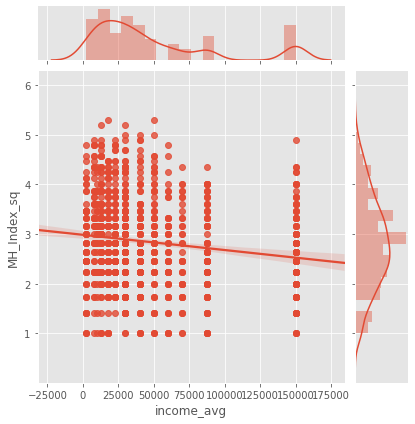

In [53]:
sns.jointplot("income_avg", "MH_Index_sq", data=select_df, kind="reg")

There seems to be some correlation here. Let's look at the normalized data.

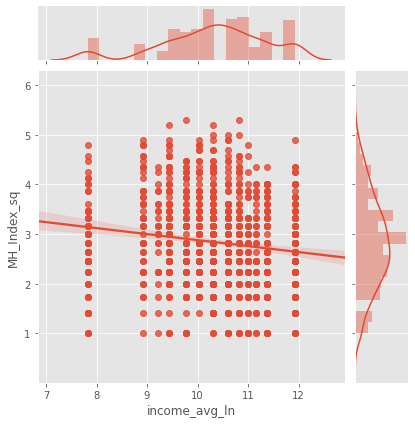

In [54]:
tmp = select_df.copy()
tmp['income_avg_ln'] = np.log(tmp.income_avg)
sns.jointplot("income_avg_ln", "MH_Index_sq", data=tmp, kind="reg")

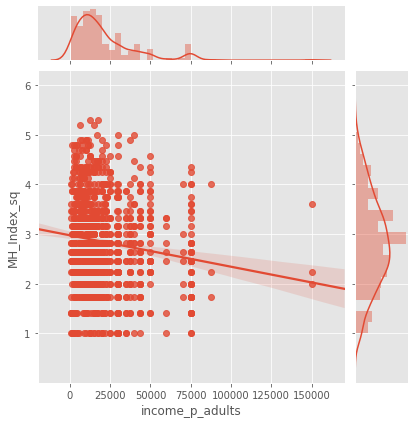

In [55]:
tmp = tmp[tmp.n_adults != 0]
tmp['income_p_adults'] = tmp.income_avg/tmp.n_adults

sns.jointplot("income_p_adults", "MH_Index_sq", data=tmp, kind="reg")


#### Missing values
Since distribution is skewed, I'll use the median ratio of income to number of adults for misisng incomes.  
I will calculate the income by multiplying median ratio to the number of adults

In [56]:
med_ratio = tmp['income_p_adults'].median()
select_df.income_avg = select_df.income_avg.fillna(select_df.n_adults * med_ratio)

### Income to household ratio
I will calculate income to household number ratio and add as a new feature.  

In [57]:
select_df['income_p_household'] = select_df['income_avg'] / select_df['total_household']

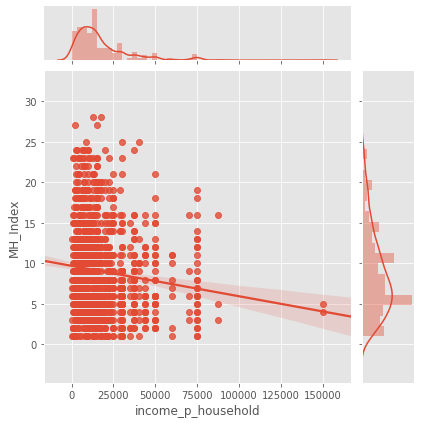

In [58]:
sns.jointplot("income_p_household", "MH_Index", data=select_df, kind="reg")

There are some outliers, but I cannot assume it's due to any error. (It's not necessarily strange that one person household has 150k income). Also it doesn't seem to be too influential compared to the overall trend.

### Marital Status
For marital status, instead of dropping nan values, I'll add a new category 'others', for people who decided not to answer or 'don't know' the answer. And treat it as a separate category.

In [59]:
select_df.DMDMARTL.isnull().sum()

52

In [60]:
select_df['marital_st'] = np.where((select_df.DMDMARTL == 77) | (select_df.DMDMARTL == 77) | (select_df.DMDMARTL.isnull()), 
         0, select_df.DMDMARTL)

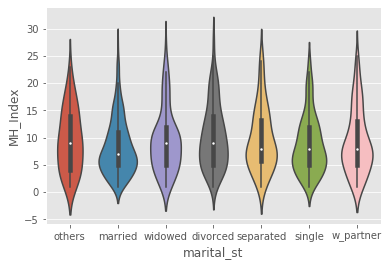

In [61]:
sns.violinplot(x="marital_st", y="MH_Index", data=select_df)
plt.xticks([0, 1, 2, 3, 4, 5, 6], 
           labels = ['others', 'married', 'widowed', 'divorced', 
                    'separated', 'single', 'w_partner'])

plt.show()

In [62]:
select_df.marital_st.value_counts()

1.0    441
5.0    251
3.0    180
2.0    121
6.0    108
4.0     68
0.0     53
Name: marital_st, dtype: int64

### Interaction (Marital St x Age)
What about interaction between marital status and age?

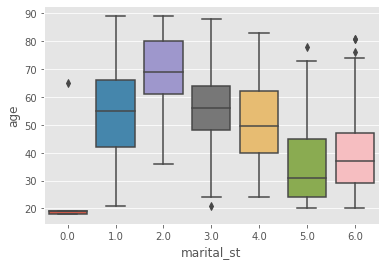

In [63]:
sns.boxplot(x = 'marital_st', y = 'age', data = select_df)

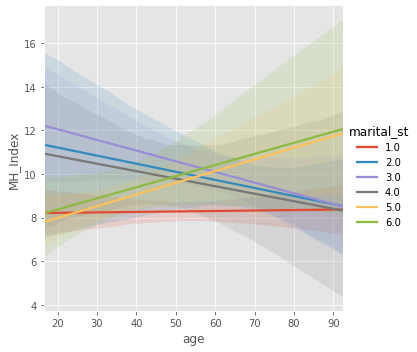

In [64]:
sns.lmplot(x = 'age', y = 'MH_Index', hue = 'marital_st', data = select_df[select_df.marital_st != 0], scatter = False)


It's messy, but it seems like some of them could be some relationship.  
Being widowed, divorced and separated may have different relationship given age.  
I'll group widowed, divorced, and separated (WDS) as one category. Then add an interaction between WDS and age and between WDS and gender.

In [65]:
select_df['WDS_marital'] = np.where((select_df.marital_st == 2) | (select_df.marital_st == 3) | (select_df.marital_st == 4), 
                                   1, 0)

In [66]:
# also never married
select_df['never_married'] = np.where((select_df.marital_st == 5) | (select_df.marital_st == 6), 1, 0)

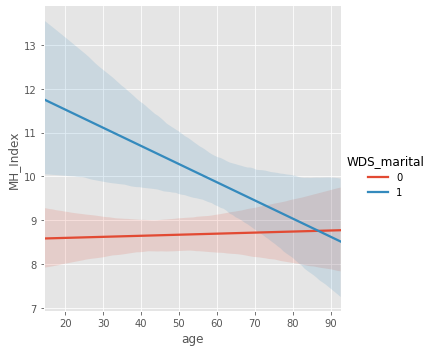

In [67]:
sns.lmplot(x = 'age', y = 'MH_Index', hue = 'WDS_marital', data = select_df, scatter = False)
# not quite but will check in the model

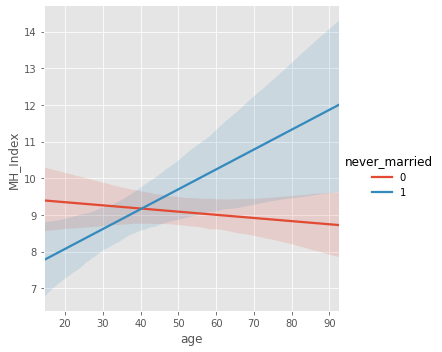

In [68]:
sns.lmplot(x = 'age', y = 'MH_Index', hue = 'never_married', data = select_df, scatter = False)
# Huge error but seems like there's a relationship

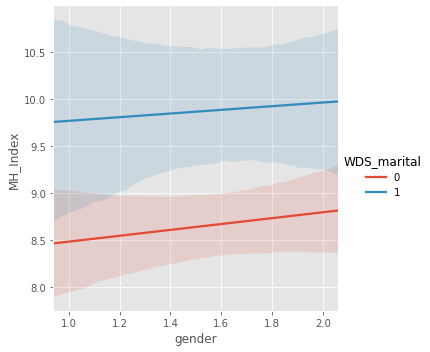

In [69]:
sns.lmplot(x = 'gender', y = 'MH_Index', hue = 'WDS_marital', data = select_df, scatter = False)
# no interaction

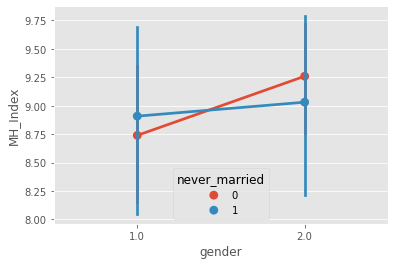

In [70]:
sns.pointplot(x = 'gender', y = 'MH_Index', hue = 'never_married', data = select_df, scatter = False)
# maybe, a little, but huge error so not likely.

### Veterans
If they have served in US Army or in foreign country, 1, otherwise 0.

In [71]:
select_df['veteran'] = np.where((select_df.DMQMILIZ == 1) | (select_df.DMQADFC == 1), 1, 0)

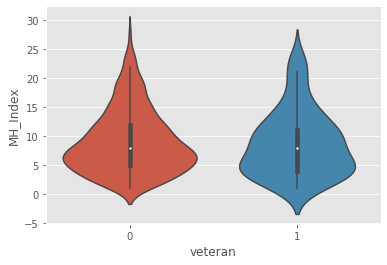

In [72]:
sns.violinplot(x="veteran", y="MH_Index", data=select_df)

### Two-sample t-test
it seems about the same.. but 1 could be lower. Let's test.  

In [73]:
st.ttest_ind(select_df.MH_Index[select_df.veteran == 1], select_df.MH_Index[select_df.veteran == 0])
# not quite significant

Ttest_indResult(statistic=-0.6214147849337005, pvalue=0.5344428377863468)

We failed to reject the null. The difference between being a veteran or not on MHI is not significant. I'll consider not including it in the model.

### Education
There are separate questions for people age 20+, and for 18, 19 years olds. I'll combine them to create a collective category.

In [74]:
cond = [(select_df.DMDEDUC2.isnull()) & ((select_df.DMDEDUC3 < 10) | (select_df.DMDEDUC3 == 66)  | (select_df.DMDEDUC3 == 55)),
        (select_df.DMDEDUC2.isnull()) & (select_df.DMDEDUC3 < 12),#Some HS
        (select_df.DMDEDUC2.isnull()) & (select_df.DMDEDUC3 <= 14),#HS & GED
        (select_df.DMDEDUC2.isnull()) & (select_df.DMDEDUC3 == 15)#Some col
       ]
vals = [1, 2, 3, 4]
select_df['education'] = np.select(cond, vals, select_df.DMDEDUC2)


In [75]:
# 9 is don't knows
select_df.education = np.where(select_df.education == 9, np.nan, select_df.education)

In [76]:
# not able to infer education of 3 missing people (high age). I'll drop these people.
select_df = select_df.dropna(subset = ['education'], axis = 0)

In [77]:
select_df.education.value_counts()

4.0    425
3.0    337
5.0    189
2.0    154
1.0    114
Name: education, dtype: int64

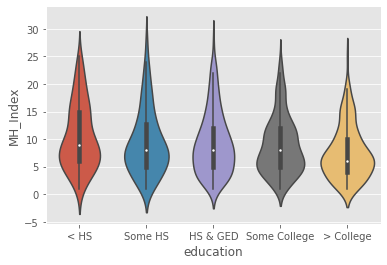

In [78]:
sns.violinplot(x="education", y="MH_Index", data=select_df)
plt.xticks([0, 1, 2, 3, 4], 
           labels = ['< HS', 'Some HS', 'HS & GED', 
                    'Some College', '> College'])
plt.show()

### Kruskal Wallis
Is there significant difference between these groups? 

In [577]:
x1 = select_df[select_df.education == 1].MH_Index
x2 = select_df[select_df.education == 2].MH_Index
x3 = select_df[select_df.education == 3].MH_Index
x4 = select_df[select_df.education == 4].MH_Index
x5 = select_df[select_df.education == 5].MH_Index

st.kruskal(x1, x2, x3, x4, x5)

KruskalResult(statistic=21.55513313732141, pvalue=0.0002457071975286712)

There are significannt difference in MHI between different education level.

### Plot
This code is here in case I want to plot all relationship.

In [79]:
# for each columns, plot scatter plot
def mass_scatter(df, y = 'MH_Index'):
    a = len(df.columns)
    ncols = math.ceil(a**.5)
    nrows = math.ceil(a/ncols)
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, 
                             figsize = (12, 12))

    axes = axes.ravel()

    for i in range(len(df.columns)):
        axes[i].scatter(df.iloc[:, i], df[y], alpha = 0.2)
        axes[i].set_title(df.columns[i])
        axes[i].get_yaxis().set_ticks([])

In [80]:
#mass_scatter(current_df)

# Number of Observations

In [81]:
len(select_df)

1219

# Data Transformation
For features I want to treat as categorical values, I'll convert them into dummy binary columns.  
Also I'll normalize skewed scalar data and standardize all non binary data that I'm treating as continuous.  
Since couple of my variables have outliers, I'll use standardization. 


In [82]:
def dummies(x, prefix):
    """
    Helper function to make dummies
    Input: series or array, prefix string
    Output: dummy dataframe
    """
    x = x.dropna(axis = 0) # drop NA and make them integers (float throws an error)
    x = x.astype('int64')
    dummy = pd.get_dummies(x, prefix = prefix, drop_first = True)
    return dummy

In [83]:
def multi_dummy(df, cat_cols):
    df0 = df.copy()
    for c in cat_cols: 
        dummy = dummies(df0[c], c)
        df0 = pd.concat([df0, dummy], axis = 1)
        df0 = df0.drop(c, axis = 1)
    return df0

#### Log transformation

In [84]:
def multi_log_transform(df, cols):
    """
    INPUT: PD Dataframe and a list of column names to be log_transformed
    OUTPUS: log_transformed df (removes existing columns)
    """
    df0 = df.copy()
    for c in cols:
        df0[f"{c}_ln"] = np.log(df0[c])
        df0 = df0.drop(c, axis = 1)
    return df0

#### Standardization

In [85]:
def scaler(x):
    """ INPUT: Pd Series """
    mean = x.mean()
    std = x.std()
    return (x-mean)/std

def df_scaler(df, cols):
    """ 
    INPUT: Pandas dataframe and a list of column names to be standardized
    OUTPUT: transformed scaler (removes existing columns)
    """
    df0 = df.copy()
    for c in cols:
        df0[f"{c}_sc"] = scaler(df0[c])
        df0 = df0.drop(c, axis = 1)
    return df0

#### Sort features

In [86]:
cols = ['MH_Index', 'gender', 'age', 'total_household',
        'n_dependents', 'n_adults', 'income_avg', 'income_p_household', 
       'marital_st', 'WDS_marital', 'veteran', 'education', 'only_adult', 'never_married']
current_df = select_df[cols]

#### Transformation

In [87]:
# I'm treating number of dependents because 
# make dummies
cat_cols = ['gender', 'marital_st', 'n_adults']
current_df = multi_dummy(current_df, cat_cols)

# log transform
log_cols = ['income_avg', 'income_p_household']
current_df = multi_log_transform(current_df, log_cols)

# Baseline Model
I will create a baseline model using above features to get baseline R2 score.

#### Check Multicollinearity

In [88]:
def corr_high(df):
    """
    INPUT: Pandas Dataframe
    OUTPUT: return a dataframe with the pair correlation above 0.7
    """
    corr_df = abs(df.corr()).stack().reset_index()
    corr_df.columns = ['v1', 'v2', 'c']
    return corr_df, corr_df[(corr_df.c > 0.7) & (corr_df.c < 1)].sort_values(
        by = 'c', ascending = False)

In [89]:
corr_high(current_df)[1]

,v1,v2,c
551,income_avg_ln,income_p_household_ln,0.836548
574,income_p_household_ln,income_avg_ln,0.836548
206,never_married,marital_st_5,0.787713
344,marital_st_5,never_married,0.787713
51,total_household,n_dependents,0.764926
74,n_dependents,total_household,0.764926


I'll remove highly correlated feature manually for the baseline model.

In [90]:
def remove_feat(df, exc_list):
    """
    INPUT: Pandas dataframe and a list of column names
    OUTPUT: dataframe without the columns in the list
    """
    df0 = df.copy()
    df0 = df0.drop(exc_list, axis = 1)
    return df0

In [91]:
X0 = remove_feat(current_df, ['income_p_household_ln', 'total_household', 'marital_st_5'])

#### Train-Test-Split
I'll get R2 score on train/test split performance to compare model.

In [92]:
# function to split the data 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

def split_df (X, y, test_size = 0.25, random_state = 42):
    """
    input: df and name of outcome column
    return: train, test for x and y
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


def test_train_score(x_tr, x_te, y_tr, y_te):
    """
    split the data and fit model
    return y_train, y_test, y_pred_train, y_pred_test, print prediction errors
    """
    linreg = LinearRegression()

    linreg.fit(x_tr, y_tr)
        
    y_pred_train = linreg.predict(x_tr)
    y_pred_test = linreg.predict(x_te)
    
    train_R2 = r2_score(y_tr, y_pred_train)
    test_R2 = r2_score(y_te, y_pred_test)
    
    print('Train R2:', train_R2)
    print('Test R2:', test_R2)

In [93]:
y = X0['MH_Index']
X = X0.drop('MH_Index', axis = 1)
x_tr, x_te, y_tr, y_te = split_df(X, y)

#### Standardize training data

In [94]:
st_cols = ['age', 'income_avg_ln', 'education', 'n_dependents']

# standardizing training data
x_tr = df_scaler(x_tr, st_cols)

# standardizing testing data 
x_te = df_scaler(x_te, st_cols)

In [95]:
test_train_score(x_tr, x_te, y_tr, y_te)

Train R2: 0.04671197402658078
Test R2: 0.02618099391918438


#### Train_test_score function
I'll make above steps as a function.

In [96]:
def tr_te_sc_func(X, y, st_cols = ['age', 'income_avg_ln', 'education', 'n_dependents']):
    # split the data
    x_tr, x_te, y_tr, y_te = split_df(X, y)
    # standardizing training data
    x_tr = df_scaler(x_tr, st_cols)
    # standardizing testing data 
    x_te = df_scaler(x_te, st_cols)
    #Output score
    test_train_score(x_tr, x_te, y_tr, y_te)

In [97]:
# Alternative CV - KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# I'll use the average KFold crossvalidation to calculate the score

def lin_avg_crossval(X, y):
    regression = LinearRegression()
    crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1)
    
    return np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))

#### Observations
Pretty poor fit we got here. I'll first test adding couple interactions we discussed to see if they explain more of the variance of the target.

# Adding More Features
# Medical Condition
Now we will look at some of the existing medical condition as features.
- BMI / obesity (if time, dietary choices)
- Chronic illness
- Chronic illness x years of living with the disease
- Disability / physical function

## Obesity
### BMI

In [98]:
select_df['BMXBMI'].isnull().sum()

19

#### Missing Value
If missing, use the gender mean. 

In [99]:
female_mean = select_df[select_df.gender == 2].BMXBMI.mean()
male_mean = select_df[select_df.gender == 1].BMXBMI.mean()

In [100]:
select_df['BMI'] = np.select([(select_df.BMXBMI.isnull()) & (select_df.gender == 2), 
                              (select_df.BMXBMI.isnull()) & (select_df.gender == 1)], 
                             [female_mean, male_mean], select_df.BMXBMI)

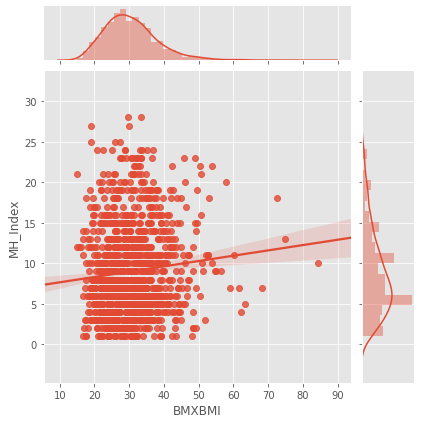

In [101]:
sns.jointplot("BMXBMI", "MH_Index", data=select_df, kind="reg")

### Sagittal abdominal diameter (Not Applicable)
-- unfortunately this measure got dropped out on more recent data. -- 

I don't like BMI because it's not an accurate measure of healthy weight vs. not healthy weight. So I want to use BMI to infer missing sagittal abdominal diameter value but drop BMI.

In [102]:
# select_df['BMDAVSAD'].isnull().sum()

In [103]:
# sns.jointplot("BMDAVSAD", "BMI", data=select_df, kind="reg")

In [104]:
# Average SAD / BMI ratio per gender
# BMI_SAD_f = (select_df[select_df.gender == 2].BMDAVSAD/select_df[select_df.gender == 2].BMI).mean()
# BMI_SAD_m = (select_df[select_df.gender == 1].BMDAVSAD/select_df[select_df.gender == 1].BMI).mean()


In [105]:
# select_df['SAD'] = np.select([(select_df.BMDAVSAD.isnull()) & (select_df.gender == 2), 
#                              (select_df.BMDAVSAD.isnull()) & (select_df.gender == 1)], 
#                             [BMI_SAD_f*select_df['BMI'], BMI_SAD_m*select_df['BMI']], 
#                             select_df.BMDAVSAD)


In [106]:
#simple_OLS(pd.concat([current_df, select_df['SAD']], axis = 1)).summary()
# Including SAD measure improves model fit more than including BMI

## Physical disability, functional impairements
Does functional impairement have an effect?  
For this, I will just have one binary column to avoid multicollinearity.   
If they have any physical difficulty (hearing, walking, seeing, dressing, bathing, doing errands alone), it will count as 1 otherwise 0.  

In [107]:
select_df['disability'] = np.where((select_df.DLQ050 == 1) | (select_df.DLQ060 == 1) |
                                  (select_df.DLQ080 == 1) | (select_df.DLQ020 == 1) | 
                                  (select_df.DLQ010 == 1), 1, 0)

In [108]:
select_df.disability.isnull().sum()

0

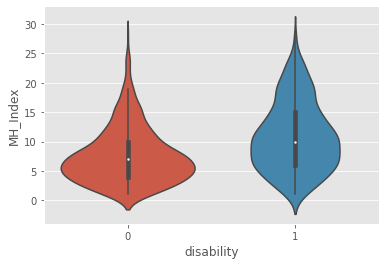

In [109]:
sns.violinplot(x="disability", y="MH_Index", data=select_df)

In [110]:
st.ttest_ind(select_df.MH_Index[select_df.disability == 0], 
             select_df.MH_Index[select_df.disability == 1])

# statistically significant difference between group

Ttest_indResult(statistic=-11.031876586127213, pvalue=4.880929230901221e-27)

## Chronic Illness 
Next question is whether the person has a chronic illness and how long a person lived with this disease. (From the experience at Suicide Hotline, it seemed to me that hopelessness is often the hardest factor to cope with.) - we will only look at cancer diagnosis for time being.

In [111]:
select_df['cancer'] = np.where((select_df.MCQ220 == 1) & (select_df.MCQ230A != 99), 1, 0)

In [112]:
# building cancer codebook for each type of cancer, age of diagnosis
# key refers to MCQ230A (what type of cancer) value
cancer_code = {10: "MCQ240A", 
 11: "MCQ240B", 
 12: "MCQ240C",
 13: "MCQ240D", 
 14: "MCQ240E",
 15: "MCQ240F",
 16: "MCQ240G", 
 17: "MCQ240H",
 18: "MCQ240I",
 19: "MCQ240J", 
 20: "MCQ240K", 
 21: "MCQ240L", 
 22: "MCQ240M", 
 23: "MCQ240N", 
 24: "MCQ240O", 
 25: "MCQ240P", 
 26: "MCQ240Q", 
 27: "MCQ240R",  
 28: "MCQ240S", 
 29: "MCQ240T", 
 30: "MCQ240U", 
 31: "MCQ240V", 
 32: "MCQ240W", 
 33: "MCQ240X", 
 34: "MCQ240Y", 
 35: "MCQ240Z", 
 36: "MCQ240AA", 
 37: "MCQ240BB", 
 38: "MCQ240CC", 
 39: "MCQ240DD", 
}

In [113]:
# find the year each cancer was diagnosed (For older dataset, newer dataset has a direct measure)
def find_year(x):
    if x['cancer'] == 1:
        c = cancer_code[x.MCQ230A]
        return x[c]
    else: 
        return x['age']
    
# select_df['cancer_d_yr'] = select_df.apply(find_year, axis = 1)

In [376]:
# find when it was diagnosed and how long it has been
select_df['cancer_d_yr'] = np.where((select_df['MCD240A'].isnull()) | (select_df['MCD240A'] == 99999), 0, 
                                     select_df['MCD240A'])

select_df['yr_since_cancer'] = np.where((select_df['cancer'] == 1), select_df['age'] - select_df['cancer_d_yr'], 0)

In [377]:
# remove negative values (possibly due to some questions with cap on the age limit)
select_df['yr_since_cancer'] = np.where(select_df['yr_since_cancer'] < 0, 0, select_df['yr_since_cancer'])

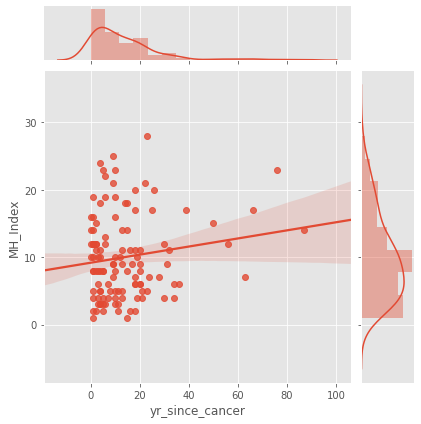

In [380]:
sns.jointplot("yr_since_cancer", "MH_Index", data=select_df[select_df.cancer == 1], kind="reg")

# Substance Abuse
## Tobacco Products
Some research suggests that tobacco smoking is a risk factor for depression. Let's explore that more.

### Smoker, nonsmoker, quitter
I'll combine couple features to create a category 'smoker'. [smoker, occ_smoker, non-smoker, quitter]

In [381]:
cond = [(select_df.SMQ020 == 1) & (select_df.SMQ040 == 1), 
        (select_df.SMQ020 == 1) & (select_df.SMQ040 == 2), 
        (select_df.SMQ020 == 1) & (select_df.SMQ040 == 3)]
vals = [3, 2, 1] #[smoker, occasional smoker, quitter, non-smoker]
select_df['smoker'] = np.select(cond, vals, 0)

### Year started smoking x Year since quitting

In [382]:
select_df['SMQ050Q'].median()

12.0

In [383]:
# adding initial year started smoking
# If don't know, add median number, if missing add 0

select_df['cig_init_yr'] = np.where(select_df['SMD030'] == 999, select_df['SMD030'].median(),
                                   select_df['SMD030'])
# adding time since quit smoking
select_df['cig_quit_yr'] = np.where(select_df['SMQ050Q'] == 99999, select_df['SMQ050Q'].median(), 
                                    np.where(select_df['SMQ050Q'] == 66666, 50, 
                                             select_df['SMQ050Q']))                           

### Average number of cigaretts per day

In [384]:
select_df['avg_n_cig'] = np.where(select_df['SMD650'] == 999, select_df['SMD650'].median(), 
                                    np.where(select_df['SMD650'] == 777, np.nan, 
                                             select_df['SMD650']))

In [385]:
# fill NA with 0
select_df['cig_init_yr'] = select_df['cig_init_yr'].fillna(0)
select_df['cig_quit_yr'] = select_df['cig_quit_yr'].fillna(0)
select_df['avg_n_cig'] = select_df['avg_n_cig'].fillna(0)

## Drug Use
### Marijuana
Frequent use of marijuana (y/n)

In [386]:
select_df['marijuana'] = np.where(select_df['DUQ211'] == 1, 1, 0)

## Cocaine
Number of time used cocaine  

In [387]:
select_df['n_cocaine'] = np.where((select_df['DUQ272'].isnull()) | 
                                  (select_df['DUQ272'] == 77), 0, 
                                 select_df['DUQ272'])

## Heroine
Ever used heroine

In [388]:
select_df['heroine'] = np.where((select_df['DUQ290'] == 1), 1, 0)

## Methamphetamine
Number of time used Meth  

In [389]:
select_df['n_meth'] = np.where((select_df['DUQ352'].isnull()), 0, 
                                 select_df['DUQ352'])

# Additional Feature Engineering
I'll run the model again with the new data and do any additional feature engineering that might be helpful.

In [452]:
cols = ['MH_Index', 'gender', 'age', 'total_household',
        'n_dependents', 'n_adults', 'income_avg', 'income_p_household', 
       'marital_st', 'WDS_marital', 'veteran', 'education', 'only_adult', 'never_married', 
       'BMI', 'disability', 'cancer', 'cancer_d_yr', 'yr_since_cancer', 'smoker', 
       'avg_n_cig', 'cig_init_yr', 'cig_quit_yr', 'marijuana', 'n_cocaine', 'heroine', 'n_meth']
current_df = select_df.copy()[cols]

#### Transformation

In [453]:
# I'm treating number of dependents because 
# make dummies
cat_cols = ['gender', 'marital_st', 'n_adults', 'smoker']
current_df = multi_dummy(current_df, cat_cols)

# log transform
log_cols = ['income_avg', 'income_p_household', 'BMI']
current_df = multi_log_transform(current_df, log_cols)

#### Deal with multi-collinearity

In [454]:
corr_high(current_df)[1]

,v1,v2,c
401,cancer,cancer_d_yr,0.917516
439,cancer_d_yr,cancer,0.917516
1441,income_avg_ln,income_p_household_ln,0.836548
1479,income_p_household_ln,income_avg_ln,0.836548
542,avg_n_cig,smoker_3,0.797701
1378,smoker_3,avg_n_cig,0.797701
337,never_married,marital_st_5,0.787713
983,marital_st_5,never_married,0.787713
81,total_household,n_dependents,0.764926
119,n_dependents,total_household,0.764926


In [458]:
X1 = current_df.copy()
exc_list = ['income_p_household_ln', 'total_household', 
            'marital_st_5', 'cig_quit_yr', 'smoker_3', 'cancer_d_yr']
X1 = remove_feat(X1, exc_list)

In [459]:
y = X1['MH_Index']
X1 = X1.drop('MH_Index', axis = 1)

tr_te_sc_func(X1, y, st_cols = ['age', 'income_avg_ln', 'education', 'n_dependents', 
                               'BMI_ln', 'yr_since_cancer', 'avg_n_cig', 'cig_init_yr', 
                                'n_cocaine', 'n_meth'])

Train R2: 0.16061588532760707
Test R2: 0.1412874632124831


Model fits look much better. Let's add some more interactions.

# Interactions
#### WDS (Widowed, Divorced, Separated) x AGE 

In [395]:
X1a = X1.copy()
X1a['WDSXAge'] = X1['WDS_marital'] * X1['age']

In [396]:
tr_te_sc_func(X1a, y)
# improved both train/test results

Train R2: 0.16462374371623667
Test R2: 0.14409627100493316


### Never Married X Age

In [397]:
X1a = X1.copy()
X1a['NeverMarriedXAge'] = X1['never_married'] * X1['age']

In [398]:
tr_te_sc_func(X1a, y)
# improved both train/test results

Train R2: 0.163553022342527
Test R2: 0.14614663320155608


### Age X Year Since Quitting Smoking

In [399]:
X1a = X1.copy()
X1a['AgeXYearQuitting'] = X1['cig_quit_yr'] * X1['age']

In [400]:
tr_te_sc_func(X1a, y)
# improved both train/test results

Train R2: 0.16269444822016177
Test R2: 0.1394016783458989


### Age X Year Started Smoking

In [401]:
X1a = X1.copy()
X1a['AgeXYearInitSmoke'] = X1['cig_init_yr'] * X1['age']

In [402]:
tr_te_sc_func(X1a, y)
# improved both train/test results

Train R2: 0.16344371928498735
Test R2: 0.1405166049529688


### Interaction Function
In order to replicate this after each model's feature selection, I'll create a function.

In [461]:
def add_interaction(df):
    df['WDSXAge'] = df['WDS_marital'] * df['age']
    df['NeverMarriedXAge'] = df['never_married'] * df['age']
    #df['AgeXYearQuitting'] = df['cig_quit_yr'] * df['age']
    df['AgeXYearInitSmoke'] = df['cig_init_yr'] * df['age']
    return df

# Model / Feature Selection 
Now I will take the final features and test couple feature selection methods and choose final one.  
I will both run train/test split data and also simple OLS. Since best performing prediction isn't my goal, I may not need to generalize the model to other data and limit my findings to research of this particular sample. So I will look at train/test split performance as well as simple OLS adjusted R-squared performance.

### Multiple Linear Regression / Least Squares

In [404]:
def simple_OLS(df, y = 'MH_Index'): # not actually simple, takes multiple reg
    """
    INPUT: dataframe and column name of target
    OUTPUT: print the summary and return model
    """
    X_col = list(df.columns)
    X_col.remove(y)
    formula = y + '~' + '+'.join(X_col)
    lm = ols(formula, data = df).fit()
    return lm

### Feature Selection 1: As Is / Dropping multicollinearity measures
This is X1 above, manually removing multicollinear variables.

In [462]:
X1B = add_interaction(X1)
tr_te_sc_func(X1B, y)

Train R2: 0.164599799643526
Test R2: 0.14995473970717976


In [464]:
#simple_OLS(pd.concat([X1B, y], axis = 1)).summary()
# Adjusted R-Squared 0.146

### Feature Selection 2: RFE
Using RFE to eliminate features

In [469]:
X_def = current_df.copy()
y = X_def['MH_Index']
X_def = X_def.drop('MH_Index', axis = 1)

In [470]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV

lin_reg = LinearRegression()
selector = RFECV(estimator = lin_reg, step = 1, cv = 10, scoring = 'r2')
#RFE(linreg, n_features_to_select=60)
selector = selector.fit(X_def, y)
X_RFE = X_def[X_def.columns[selector.support_]]

In [472]:
# add interactions
X_RFE['WDSXAge'] = X_RFE['WDS_marital'] * X_RFE['age']
X_RFE['NeverMarriedXAge'] = X_RFE['never_married'] * X_RFE['age']

In [473]:
st_cols = ['age', 'cancer_d_yr', 'n_cocaine', 'n_meth','income_avg_ln',
       'income_p_household_ln', 'BMI_ln']

tr_te_sc_func(X_RFE, y, st_cols = st_cols)
# training performance is okay, but test performance dropped significantly.

Train R2: 0.16772477909317296
Test R2: 0.14011221042122435


In [481]:
#simple_OLS(pd.concat([X_RFE, y], axis = 1)).summary()
# Adjusted R-Squared 0.150

### Feature Selection 3: VIF
Using VIF to drop a collinear measure. 

In [438]:
X_def = current_df.copy()
y = X_def['MH_Index']
X_def = X_def.drop('MH_Index', axis = 1)

In [439]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif_(df_feat):
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(df_feat.values, i) for i in range(df_feat.shape[1])]
    vif["features"] = df_feat.columns
    vif.round(1)
    return vif, vif[(vif['VIF Factor'] != np.inf) & (vif['VIF Factor'] > 10)
              ].sort_values(by = "VIF Factor", ascending = False).features
               
               
# feature to remove
rmfeats1 = vif_(X_def)[1]

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [440]:
X_VIF = X_def.drop(rmfeats1, axis = 1)

In [441]:
# add interaction
X_VIF['WDSXAge'] = X_VIF['WDS_marital'] * X_VIF['age']
X_VIF['NeverMarriedXAge'] = X_VIF['never_married'] * X_VIF['age']

In [442]:
tr_te_sc_func(X_VIF, y, st_cols = ['age', 'education', 'n_dependents'])
# training performance is okay, but test performance dropped significantly.

Train R2: 0.16481350361134806
Test R2: -1.2452051215043353e+19


In [443]:
#simple_OLS(pd.concat([X_VIF, y], axis = 1)).summary()
# Adjusted R-Squared 0.147

### (Alternative 1) Stepwise Selection
(Code from Learn.co)

In [476]:
## Code from Learn.co
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


In [479]:
result = stepwise_selection(X_def, y, verbose=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  disability                     with p-value 4.88093e-27
Add  n_cocaine                      with p-value 1.705e-08
Add  marital_st_1                   with p-value 0.000301839
Add  smoker_3                       with p-value 0.00261585


### (Alternative 2) Lasso

In [444]:
from sklearn.linear_model import Lasso
def lasso_val(X, y):
    lasso = Lasso(alpha = 1, normalize = True, tol=0.1, max_iter = 10000)
    param = {'alpha': [10**-15, 10**-10, 10**-8, 10**-4, 10**-3, 
                           10**-2, 1, 5, 10, 20]}
    lasso_reg = GridSearchCV(lasso, param, scoring = 'r2', cv = 5)
    lasso_reg.fit(X, y)
    return lasso_reg.best_score_

# Final Model
Using RFE feature selection yielded the highest adjusted R-squared and even though it did slightly worse on test data on train/test split. I will use RFE feature selection for higher adjusted R-squared.

In [503]:
X_def = current_df.copy()
y = X_def['MH_Index']
X_def = X_def.drop('MH_Index', axis = 1)

In [504]:
# RFE Selection
lin_reg = LinearRegression()
selector = RFECV(estimator = lin_reg, step = 1, cv = 10, scoring = 'r2')
selector = selector.fit(X_def, y)
FinX = X_def[X_def.columns[selector.support_]]

In [505]:
# scaling columns
st_cols = ['age', 'cancer_d_yr', 'n_cocaine', 'n_meth','income_avg_ln',
       'income_p_household_ln', 'BMI_ln', 'education', 'total_household']

FinX = df_scaler(FinX, st_cols) # scale# training performance is okay, but test performance dropped significantly.

In [507]:
# add interactions
FinX['WDSXAge'] = FinX['WDS_marital'] * FinX['age_sc']
FinX['NeverMarriedXAge'] = FinX['never_married'] * FinX['age_sc']
FinX['AgeXEducation'] = FinX['education_sc'] * FinX['age_sc']
FinX['OnlyAdultXTotalHousehold'] = FinX['only_adult'] * FinX['total_household_sc']

In [508]:
# fit model
fin_model = simple_OLS(pd.concat([FinX, y], axis = 1))
#fin_model.summary()

Additionally, I decided to test removing features with highest p-value from the model one at a time, as long as it improves the model fit (Adjusted R-Squared)

In [644]:
# The iterative process is not reflected on the code, because I did it manually to check overall result each time.
# but the order of low_p is the order it was removed.
low_p = ['marital_st_2', 'WDS_marital', 'marital_st_4', 'marital_st_6', 'never_married', 'veteran', 
        'smoker_1', 'n_adults_4', 'n_meth_sc', 'n_adults_3', 'n_adults_2', 'n_dependents', 'n_adults_6',
        'marital_st_5', 'WDSXAge', 'only_adult', 'AgeXEducation', 'heroine', 'OnlyAdultXTotalHousehold',
        'total_household_sc','smoker_2']

tmp = FinX.drop(low_p, axis = 1)
FIN_model = simple_OLS(pd.concat([tmp, y], axis = 1))
FIN_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               MH_Index   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     14.21
Date:                Fri, 31 Jul 2020   Prob (F-statistic):           1.34e-37
Time:                        08:36:22   Log-Likelihood:                -3692.3
No. Observations:                1219   AIC:                             7421.
Df Residuals:                    1201   BIC:                             7513.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    6.9096      0.383     18.052      0.000       6.159       7.661
disability                   3.2099      0.322      9.975      0.000       2.579       3.841
cancer                       3.7632      1.242      3.030      0.003       1.326       6.200
marijuana                    0.7447      0.419      1.775      0.076      -0.078       1.568
gender_2                     0.5349      0.304      1.759      0.079      -0.062       1.132
marital_st_1                -0.5668      0.364     -1.556      0.120      -1.281       0.148
marital_st_3                 0.6291      0.453      1.388      0.165      -0.260       1.518
n_adults_5                  -1.6251      0.841     -1.932      0.054      -3.276       0.025
n_adults_7                   7.5037      5.082      1.477      0.140      -2.467      17.474
smoker_3                     0.8871      0.376      2.361      0.018       0.150       1.624
age_sc                      -0.6583      0.215     -3.064      0.002      -1.080      -0.237
cancer_d_yr_sc              -1.0153      0.372     -2.732      0.006      -1.744      -0.286
n_cocaine_sc                 0.5218      0.167      3.124      0.002       0.194       0.850
income_avg_ln_sc            -0.6092      0.312     -1.950      0.051      -1.222       0.004
income_p_household_ln_sc     0.5710      0.313      1.822      0.069      -0.044       1.186
BMI_ln_sc                    0.2751      0.148      1.853      0.064      -0.016       0.566
education_sc                -0.4724      0.157     -3.000      0.003      -0.781      -0.163
NeverMarriedXAge             0.8294      0.369      2.248      0.025       0.106       1.553
==============================================================================
Omnibus:                       90.328   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.076
Skew:                           0.720   Prob(JB):                     2.06e-24
Kurtosis:                       3.270   Cond. No.                         50.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Assumptions of Linear Regression
Lastly, making sure residuals are approximately normal and homos

In [633]:
y_pre = FIN_model.predict(FinX)

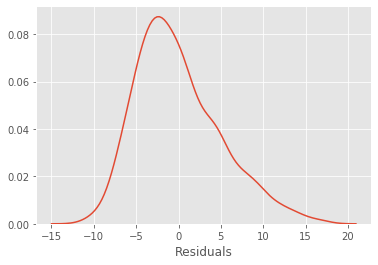

In [634]:
sns.distplot((y-y_pred), hist = False)
plt.xlabel("Residuals")
plt.show()
# it seems like our residual is "approximately (very liberally speaking)" normal

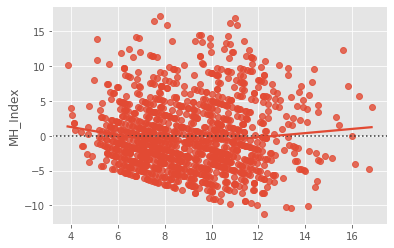

In [604]:
sns.residplot(y_pred, y, lowess = True)
plt.show()
# High variance, but generally it doesn't seem to be violating the assumption of homoscedasticity (too much)
# slight over-estimation on either end.

# Conclusion/ Interpretation
I'll review some points of the final model.  

In [599]:
#fin_model.summary()

Some of the findings...   
 
Mental health is a complex issue it is very difficult to narrow down all the factors that may contribute to one’s mental health progression, and the resulting model has a very low goodness of fit. But below I report some of the meaningful factors that attributed to MHI score difference with p-value less than 0.5. 
1. Having a disability was also a key predictor of frequent experience of depressive symptoms, contributing to approximately 3.2 points increase in MHI.
2. Chronic illness such as cancer is a key predictor of frequent experience of depressive symptoms. Having cancer contributed to approximately 3.8 points increase in MHI. One way to get this much score increase is going from experiencing no symptom to experiencing one of the symptoms all the time. 
3. Moreover, each standard deviation increase in year of diagnosis (shorter time to the current time) attributed to 1 point decrease in MHI. 
4. Next important key factor is the use of substances. Being a smoker attributes to 0.9 point increase in MHI.
5. Higher average number of daily cocaine use increase also attributed significantly to higher MHI (coef = 0.52).
6. Next to year of diagnosis of cancer, increase of age without ever married was the next highest predictor of increase in MHI.
7. Additionally education level are also important key factors of MHI. (Higher education, the lower MHI score.)Mental health is a complex issue it is very difficult to narrow down all the factors that may contribute to one’s mental health progression, and the resulting model has a very low goodness of fit. But below I report some of the factors with p-value lower than 0.5. 
1. Having a disability was also a key predictor of frequent experience of depressive symptoms, contributing to approximately 3.2 points increase in MHI.
2. Chronic illness such as cancer is a key predictor of frequent experience of depressive symptoms. Having cancer contributed to approximately 3.8 points increase in MHI. One way to get this much score increase is going from experiencing no symptom to experiencing one of the symptoms all the time. 
3. Moreover, each standard deviation increase in year of diagnosis (shorter time to the current time) attributed to 1 point decrease in MHI. 
4. Next important key factor is the use of substances. Being a smoker attributes to 0.9 point increase in MHI.
5. Higher average number of daily cocaine use increase also attributed significantly to higher MHI (coef = 0.52).
6. Next to year of diagnosis of cancer, increase of age without ever married was the next highest predictor of increase in MHI.
7. Additionally education level are also important key factors of MHI. (Higher education, the lower MHI score.)

# Visualization
Some additional plotting to explain results.

In [513]:
visdat = pd.concat([FinX, y, y_pred], axis = 1)

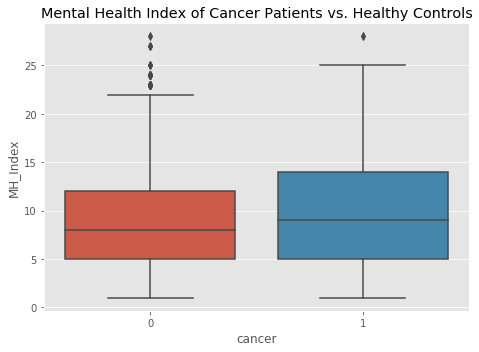

In [527]:
# Barplot comparing the average cancer patient's MH_Index to others
plt.figure(figsize = (7, 5))
sns.boxplot(x = 'cancer', y = 'MH_Index', data = visdat)
plt.title("Mental Health Index of Cancer Patients vs. Healthy Controls")
plt.tight_layout()
plt.savefig("PNG/cancer.png")
plt.show()

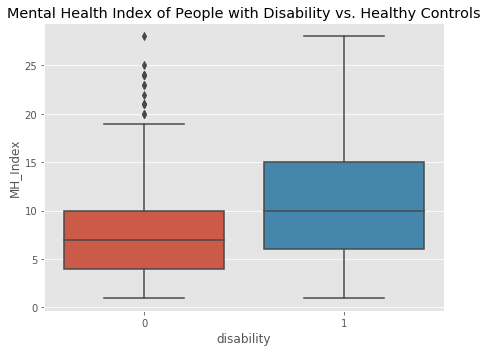

In [528]:
# Barplot comparing the people with disability MH_Index to others
plt.figure(figsize = (7, 5))
sns.boxplot(x = 'disability', y = 'MH_Index', data = visdat)
plt.title("Mental Health Index of People with Disability vs. Healthy Controls")

plt.tight_layout()
plt.savefig("PNG/disability.png")
plt.show()

<Figure size 504x360 with 0 Axes>

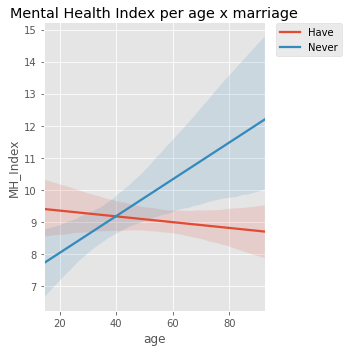

In [651]:
plt.figure(figsize = (7, 5))
sns.lmplot(x = 'age', y = 'MH_Index', hue = 'never_married', data = current_df, scatter = False, legend = False)
plt.legend(['Have', 'Never'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Mental Health Index per age x marriage")

plt.tight_layout()
plt.savefig("PNG/never_married.png")
plt.show()

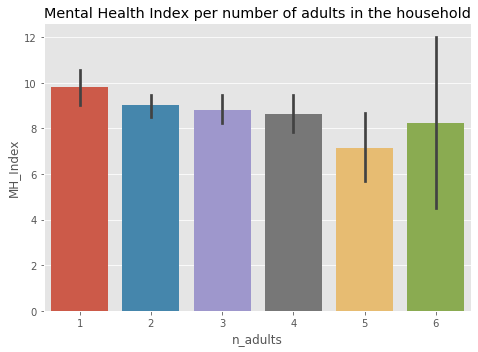

In [529]:
plt.figure(figsize = (7, 5))
sns.barplot(x = 'n_adults', y = 'MH_Index', data = select_df[select_df.n_adults != 7])
plt.title("Mental Health Index per number of adults in the household")

plt.tight_layout()
plt.savefig("PNG/n_adults.png")
plt.show()

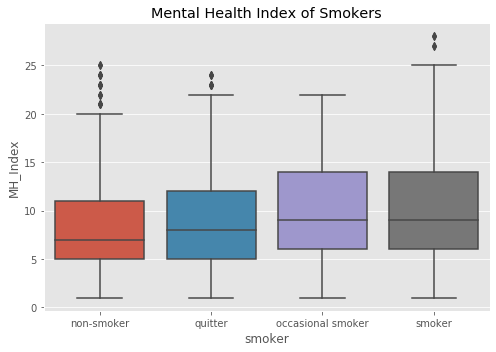

In [576]:
# Barplot comparing the people with disability MH_Index to others
plt.figure(figsize = (7, 5))
sns.boxplot(x = 'smoker', y = 'MH_Index', data = select_df)
plt.title("Mental Health Index of Smokers")
plt.xticks([0, 1, 2, 3], ['non-smoker', 'quitter', 'occasional smoker', 'smoker'])
plt.tight_layout()
plt.savefig("PNG/smoker.png")
plt.show()

<Figure size 504x360 with 0 Axes>

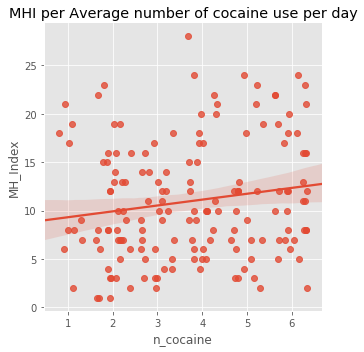

In [548]:
plt.figure(figsize = (7, 5))
sns.lmplot(x = 'n_cocaine', y = 'MH_Index', data = current_df[current_df.n_cocaine != 0], x_jitter=.4)
plt.title("MHI per Average number of cocaine use per day")
plt.tight_layout()
plt.savefig("PNG/cocaine.png")
plt.show()

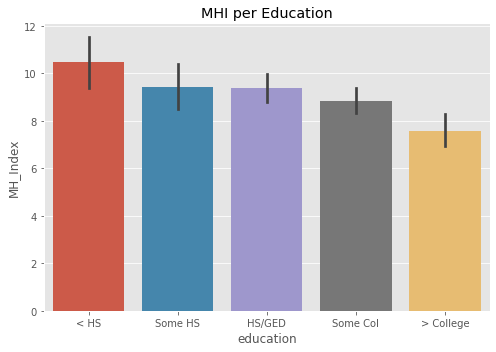

In [554]:
plt.figure(figsize = (7, 5))
sns.barplot(x = 'education', y = 'MH_Index', data = current_df)
plt.title("MHI per Education")
plt.xticks([0, 1, 2, 3, 4], ['< HS', 'Some HS', 'HS/GED', 'Some Col', '> College'])
plt.tight_layout()
plt.savefig("PNG/education.png")
plt.show()